In [1]:
from models import Actor, Critic
from DDPG import DDPG_Agent
from tools import PlotTool

from unityagents import UnityEnvironment
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")



import numpy as np
import random
from collections import deque

from tqdm import tqdm_notebook as tqdm
from ipywidgets import *
from IPython.display import display
import matplotlib.pyplot as plt
%matplotlib notebook

## Load the Enviornment

In [2]:
env         = UnityEnvironment(file_name="../Reacher_Linux_2/Reacher.x86_64", no_graphics=True)
brain_name  = env.brain_names[0]
brain       = env.brains[brain_name]
env_info    = env.reset(train_mode=True)[brain_name]

DEBUG:unityagents:The true file name is Reacher
DEBUG:unityagents:This is the launch string /home/yousof/AI/courses/deep_RL_udacity/projects/DRLND_Continuous_Control_P2/../Reacher_Linux_2/Reacher.x86_64
INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_size -> 5.0
		goal_speed -> 1.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [ ]:
num_agents  = len(env_info.agents)
action_size = brain.vector_action_space_size
state_size  = len(env_info.vector_observations[0])
print("state size:",state_size, "action size:", action_size)
print("state shape: ", env_info.vector_observations.shape)

state size: 33 action size: 4
state shape:  (20, 33)


## Train the Agent

In [ ]:
agent = DDPG_Agent(state_size=state_size, 
                   action_size=action_size, 
                   actor_model=Actor,
                   critic_model=Critic,
                   device=device,
                   num_agents= num_agents, 
                   seed=1,
                   tau=5e-2,
                   batch_size=2048,
                   discount_factor = 0.99,
                   actor_learning_rate=1e-5,
                   critic_learning_rate=1e-4)

<IPython.core.display.Javascript object>


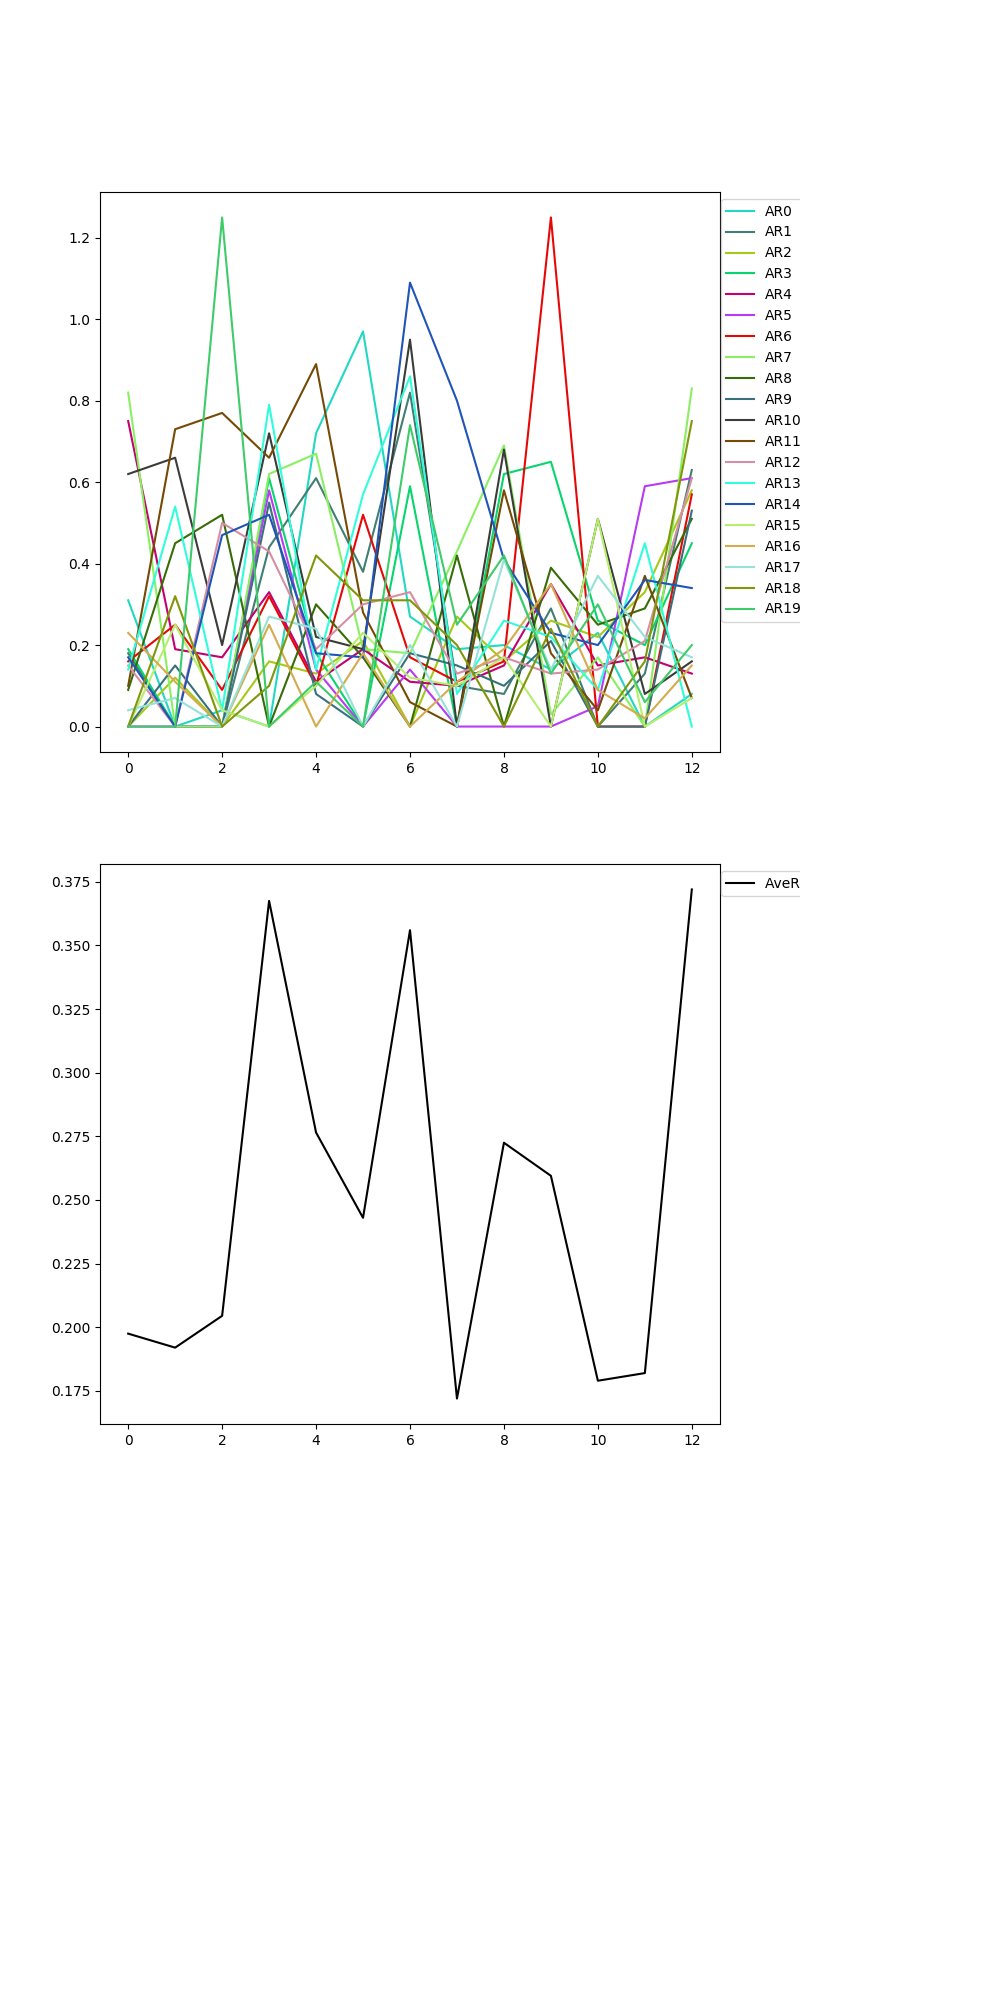

<IPython.core.display.Javascript object>


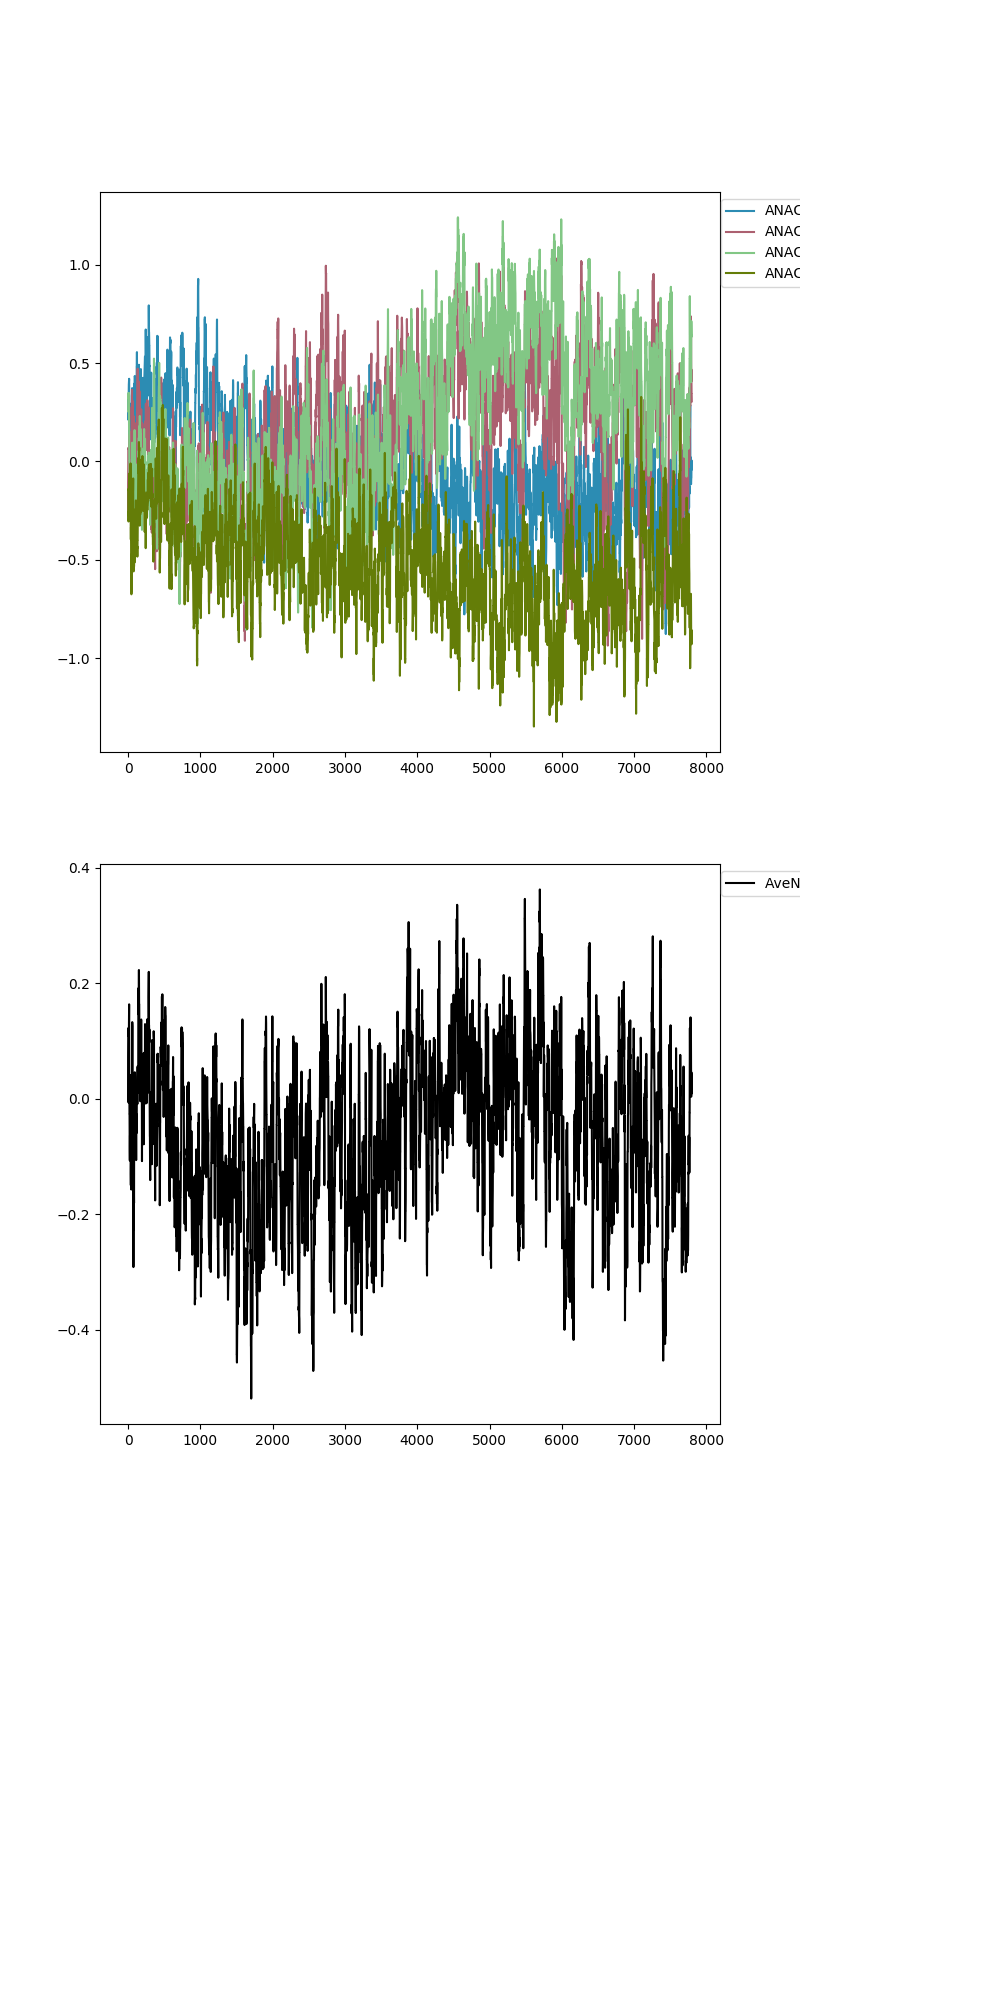

<IPython.core.display.Javascript object>


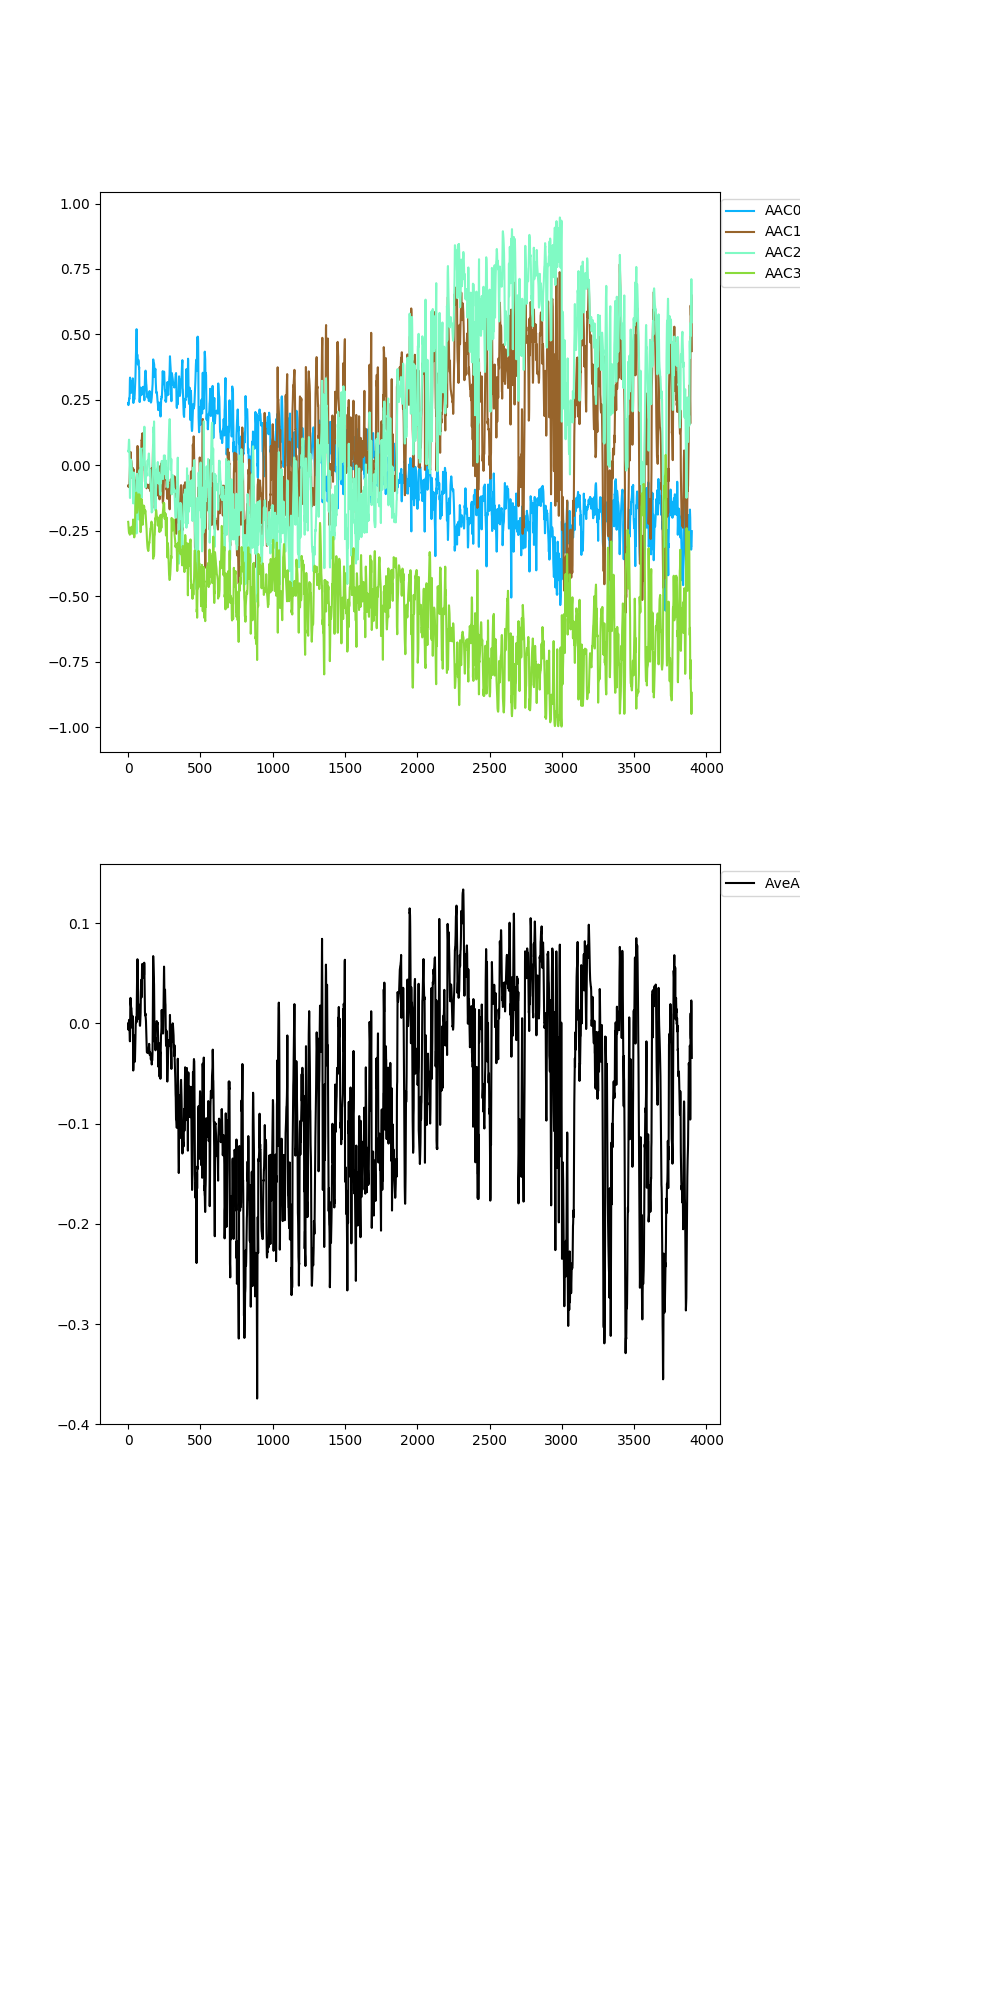

<IPython.core.display.Javascript object>


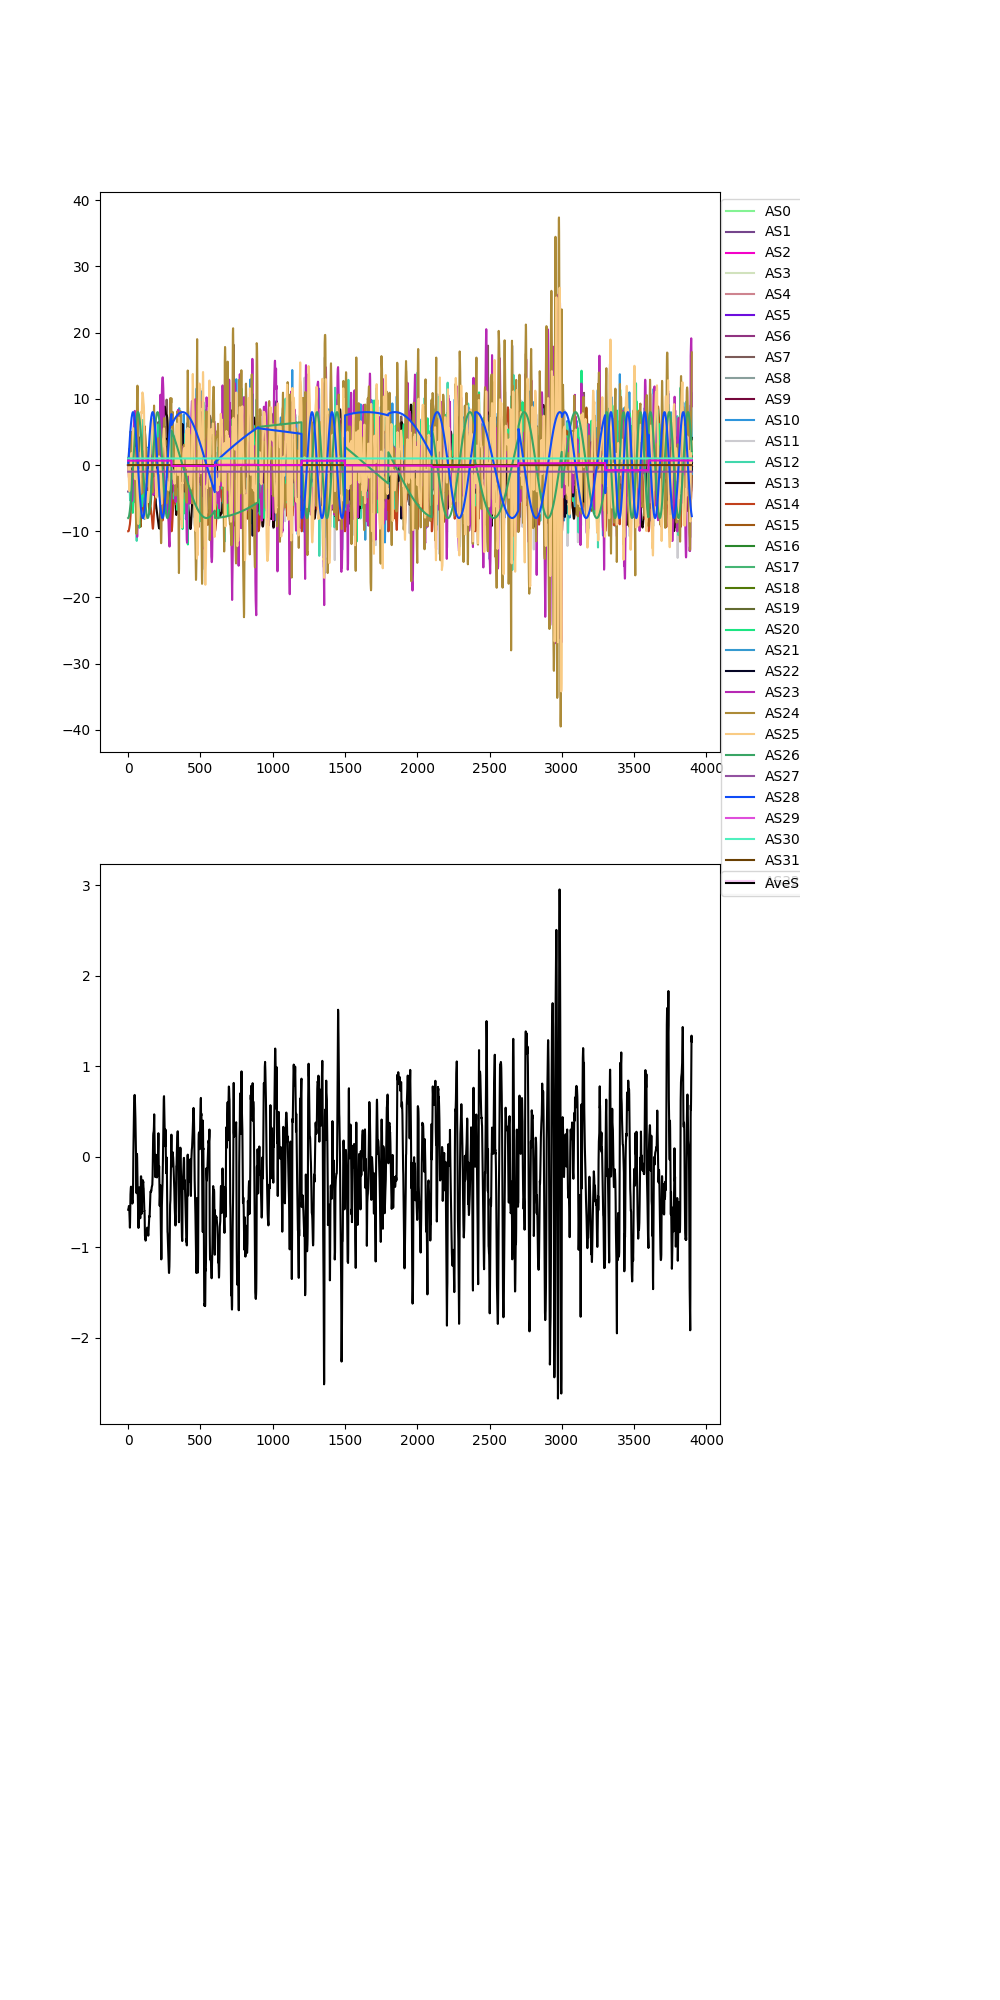

Label(value='Episode 0\tAverage Score: 0.00')

In [ ]:
def ddpg(n_episodes=1000, max_t=300, print_every=100):
    scores_deque = deque(maxlen=print_every)
    scores = []
    score = np.zeros(num_agents)
    
    # commenting and plotting
    desc = Label('Episode {}\tAverage Score: {:.2f}'.format(0,0))
    display(desc)
    tqm = tqdm(range(1, n_episodes+1))
    for i_episode in tqm:
        env_info    = env.reset(train_mode=True)[brain_name]
        states      = env_info.vector_observations
        agent.reset()
        score = 0
        for t in range(max_t):
            statePlotter.push_date(states[2,:].reshape(1,state_size))
            actions_with_noise, actions_without_noise  = agent.act(states,add_noise=True)
            actionPlotter.push_date(actions_with_noise[2,:].reshape(1,action_size))
            actionPlotterWithoutNoise.push_date(actions_without_noise[2,:].reshape(1,action_size))
            actions = np.clip(actions_with_noise, -1, 1)
            actionPlotter.push_date(actions[2,:].reshape(1,action_size))
            env_info = env.step(actions)[brain_name]
            next_states = env_info.vector_observations
            reward = env_info.rewards
            done = env_info.local_done
            agent.step(state      = states,
                       action     = actions,
                       reward     = reward,
                       next_state = next_states, 
                       done       = done
                      )
            states = next_states
            score = score + np.array(reward)
            if np.any(done):
                break 
        actionPlotter.draw()
        actionPlotterWithoutNoise.draw()
        statePlotter.draw()
        rewardPlot.push_date(score.reshape(1, num_agents))
        rewardPlot.draw()
        scores_deque.append(score)
        scores.append(score)
        score_mean_circular = np.mean(scores_deque)
        desc.value = 'Episode {},'.format(i_episode)+ \
                     '\tMinimum Score: {:.2f},'.format(np.min(scores_deque))+ \
                     '\tAverage Score: {:.2f},'.format(score_mean_circular)
        
        
        if score_mean_circular > 35:
            # enough training
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
            break
            
    return scores

%matplotlib notebook
rewardPlot = PlotTool(number_of_lines=num_agents, desc = "R" )
actionPlotter = PlotTool(number_of_lines=action_size, desc = "NAC")
actionPlotterWithoutNoise = PlotTool(number_of_lines=action_size, desc = "AC")
statePlotter = PlotTool(number_of_lines=state_size, desc = "S")
scores = ddpg(n_episodes=10000, max_t=300)